# **Music Recommendation System** 

**Importing Libraries**

In [1]:
# Music Recommendation System using Clustering
# Optimized for Google Colab

# Install required packages
!pip install -q pandas numpy scikit-learn matplotlib seaborn plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("MUSIC RECOMMENDATION SYSTEM USING CLUSTERING")
print("=" * 80)

MUSIC RECOMMENDATION SYSTEM USING CLUSTERING


**Data Acquisition**

In [2]:
print("\n[STEP 1] Loading Dataset...")

# Using Spotify Dataset from Kaggle (accessible via direct link)
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv"

try:
    df = pd.read_csv(url)
    print(f"✓ Dataset loaded successfully!")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    print("Using sample data instead...")
    # Fallback sample data
    np.random.seed(42)
    df = pd.DataFrame({
        'track_name': [f'Song_{i}' for i in range(1000)],
        'track_artist': [f'Artist_{i%100}' for i in range(1000)],
        'track_popularity': np.random.randint(0, 100, 1000),
        'playlist_genre': np.random.choice(['pop', 'rock', 'hip hop', 'edm', 'latin'], 1000),
        'danceability': np.random.random(1000),
        'energy': np.random.random(1000),
        'key': np.random.randint(0, 11, 1000),
        'loudness': np.random.uniform(-20, 0, 1000),
        'mode': np.random.randint(0, 2, 1000),
        'speechiness': np.random.random(1000),
        'acousticness': np.random.random(1000),
        'instrumentalness': np.random.random(1000),
        'liveness': np.random.random(1000),
        'valence': np.random.random(1000),
        'tempo': np.random.uniform(60, 200, 1000),
        'duration_ms': np.random.uniform(120000, 300000, 1000)
    })


[STEP 1] Loading Dataset...
✓ Dataset loaded successfully!
  Shape: (32833, 23)
  Columns: ['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


**Exploratory Data Analysis**


[STEP 2] Exploratory Data Analysis...

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  

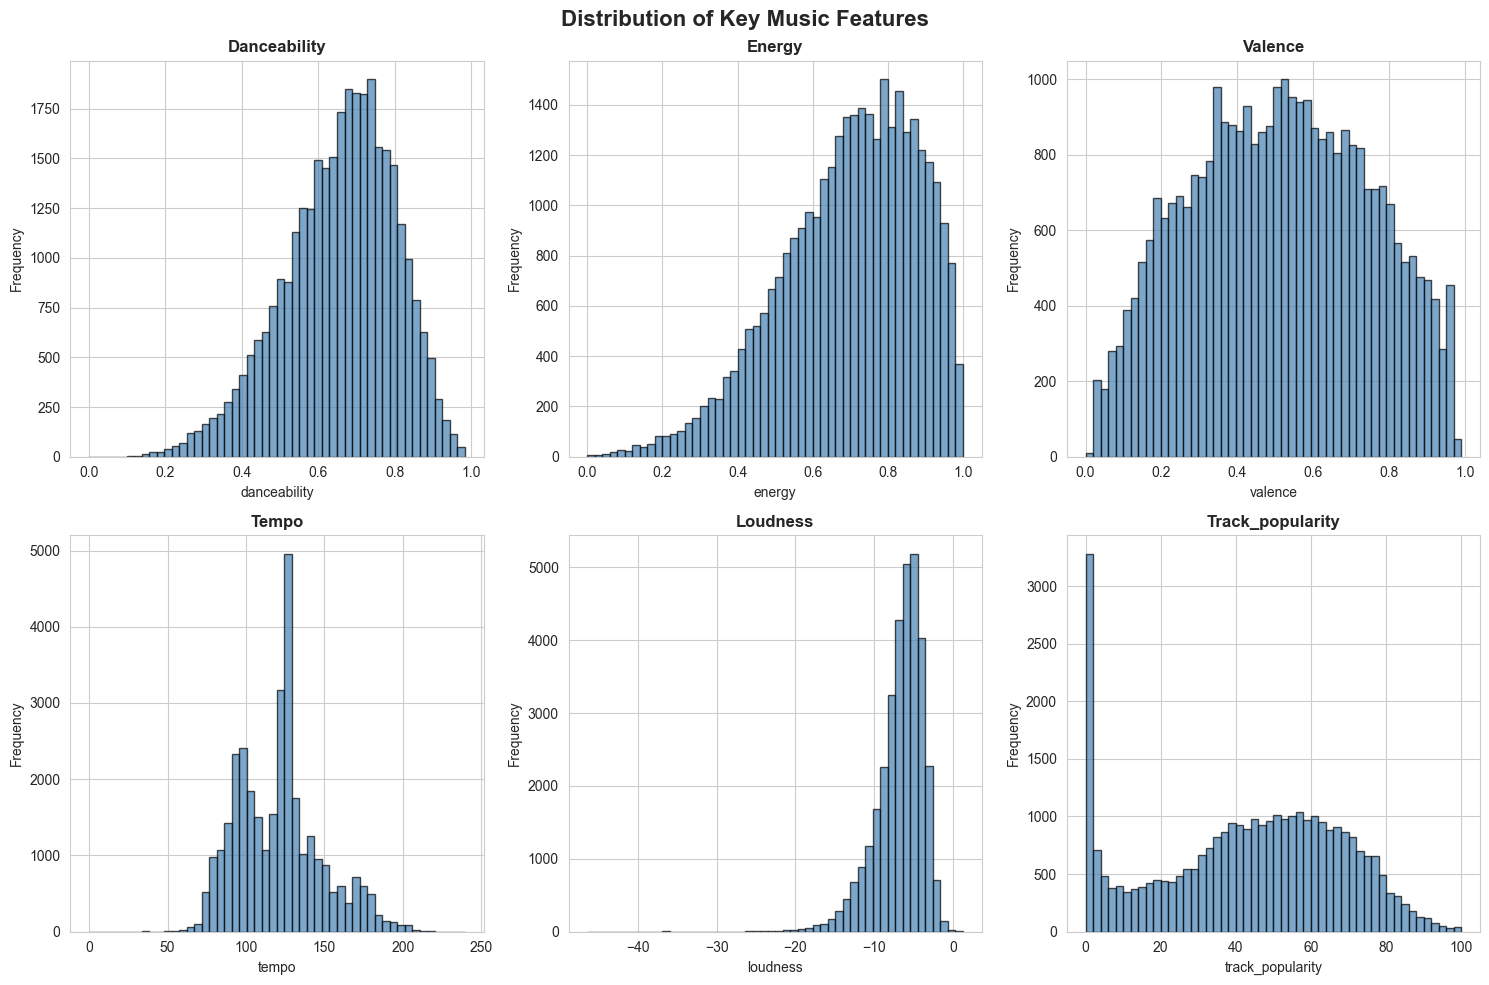

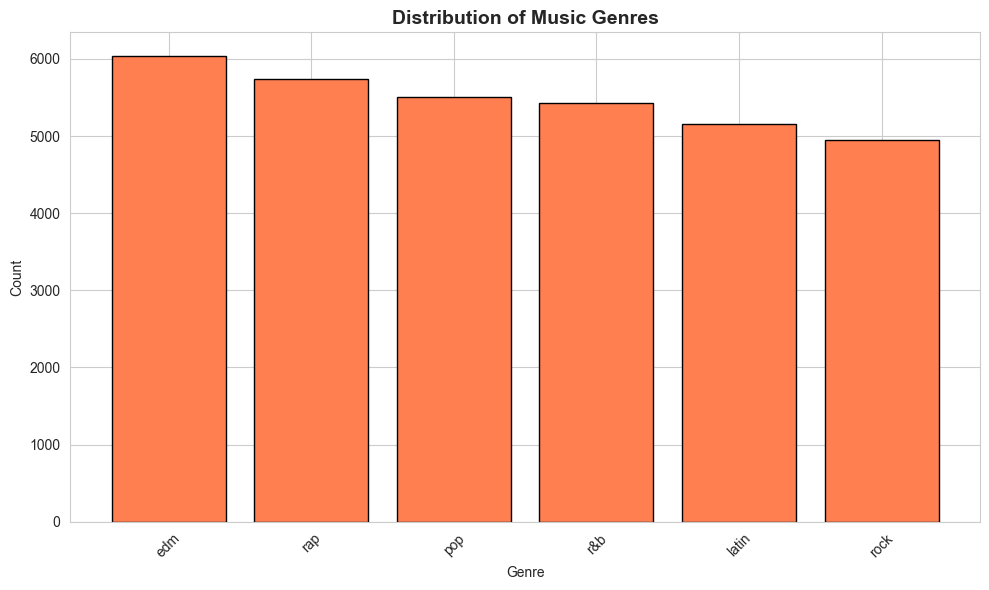

In [3]:
print("\n[STEP 2] Exploratory Data Analysis...")

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Music Features', fontsize=16, fontweight='bold')

features_to_plot = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'track_popularity']
for idx, feature in enumerate(features_to_plot):
    if feature in df.columns:
        ax = axes[idx // 3, idx % 3]
        ax.hist(df[feature].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'{feature.capitalize()}', fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Genre distribution
if 'playlist_genre' in df.columns:
    plt.figure(figsize=(10, 6))
    genre_counts = df['playlist_genre'].value_counts()
    plt.bar(genre_counts.index, genre_counts.values, color='coral', edgecolor='black')
    plt.title('Distribution of Music Genres', fontsize=14, fontweight='bold')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Data Preprocessing**

In [4]:
print("\n[STEP 3] Data Preprocessing...")

# Select numerical features for clustering
feature_columns = ['danceability', 'energy', 'loudness', 'speechiness', 
                   'acousticness', 'instrumentalness', 'liveness', 
                   'valence', 'tempo', 'duration_ms']

# Filter available columns
feature_columns = [col for col in feature_columns if col in df.columns]
print(f"Features selected for clustering: {feature_columns}")

# Create feature matrix
df_clean = df[feature_columns].dropna()
print(f"Clean dataset shape: {df_clean.shape}")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
print("✓ Features scaled using StandardScaler")

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"✓ PCA completed - Explained variance: {pca.explained_variance_ratio_.sum():.2%}")


[STEP 3] Data Preprocessing...
Features selected for clustering: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Clean dataset shape: (32833, 10)
✓ Features scaled using StandardScaler
✓ PCA completed - Explained variance: 36.97%


**K-means Clustering**


[STEP 4] K-Means Clustering...
Finding optimal K using Elbow Method...
  K=2: Inertia=283346.88, Silhouette=0.176
  K=3: Inertia=255753.09, Silhouette=0.126
  K=4: Inertia=234481.31, Silhouette=0.133
  K=5: Inertia=216335.33, Silhouette=0.135
  K=6: Inertia=203541.40, Silhouette=0.137
  K=7: Inertia=193537.21, Silhouette=0.126
  K=8: Inertia=185760.48, Silhouette=0.122
  K=9: Inertia=178768.80, Silhouette=0.123
  K=10: Inertia=172348.69, Silhouette=0.127


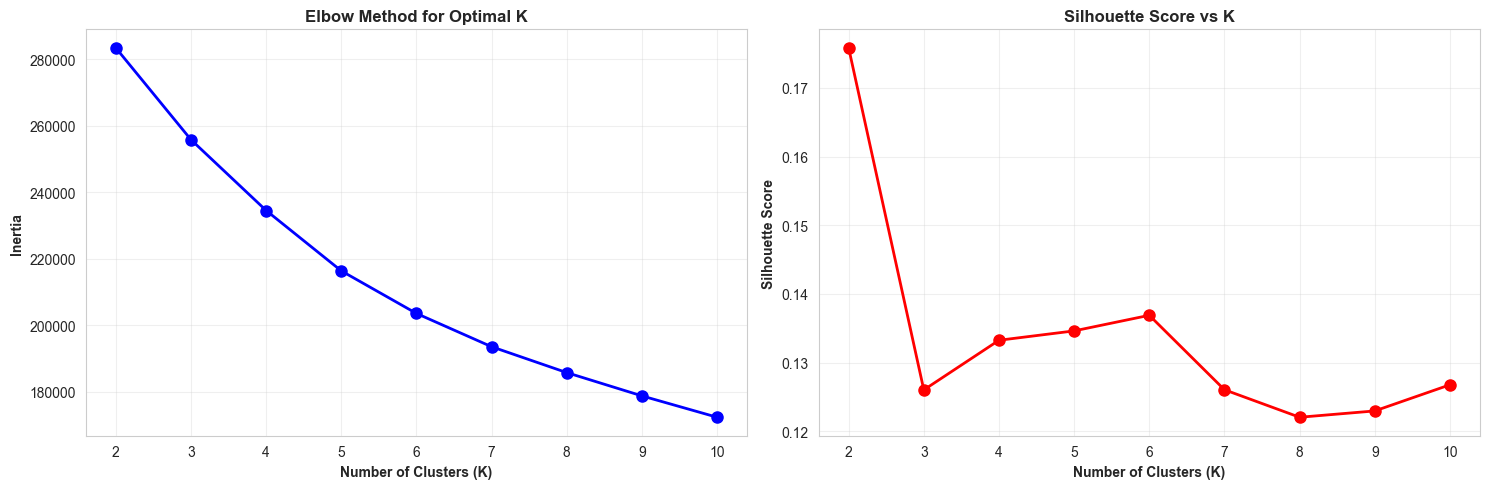


✓ Optimal K selected using Elbow Method: 4
   (Alternative threshold method suggested: 6)
   (Silhouette score method would suggest: 2)

K-Means Evaluation Metrics:
  Silhouette Score: 0.133
  Davies-Bouldin Index: 1.977
  Calinski-Harabasz Score: 4379.83


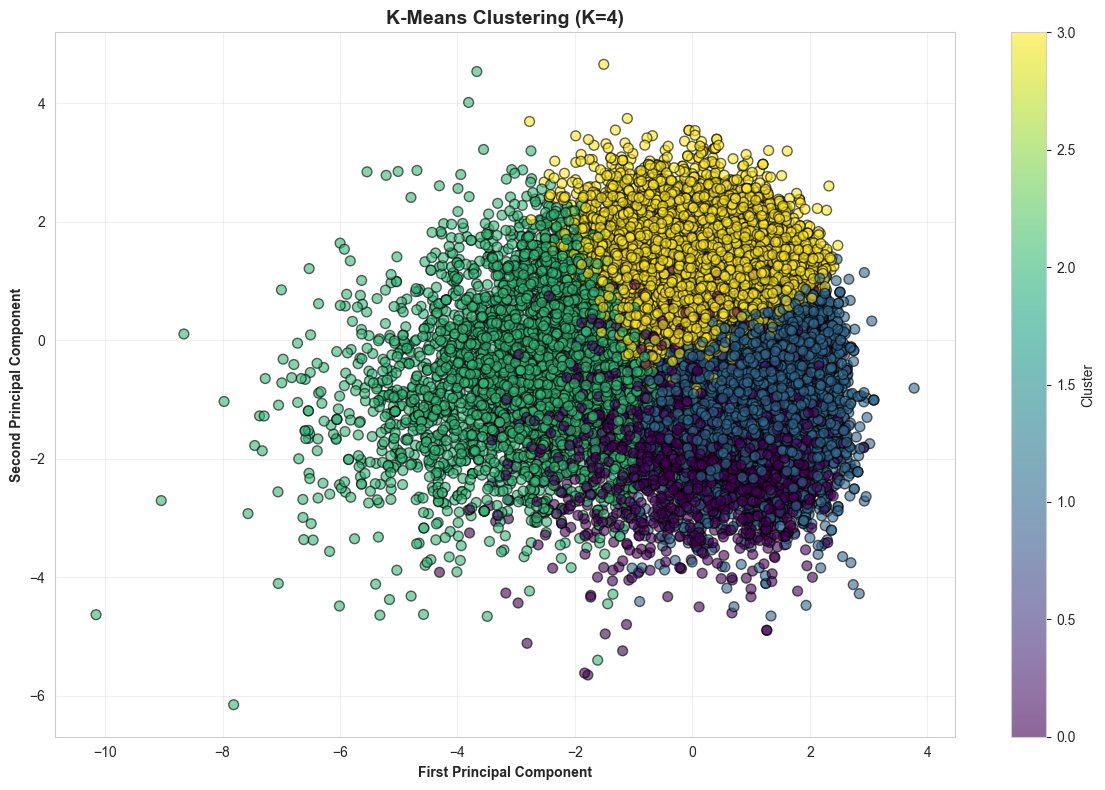

In [13]:
print("\n[STEP 4] K-Means Clustering...")

# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("Finding optimal K using Elbow Method...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"  K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot Elbow Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax1.set_ylabel('Inertia', fontweight='bold')
ax1.set_title('Elbow Method for Optimal K', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Score vs K', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal K using Elbow Method
# Calculate the rate of change in inertia
deltas = np.diff(inertias)
second_deltas = np.diff(deltas)

# Find the elbow point (where the curve bends most)
# Use the point where second derivative is maximum
elbow_index = np.argmax(second_deltas) + 2  # +2 because we took diff twice and start from K=2

# Alternative: Use a threshold-based approach
# Find where improvement becomes less than 15% of previous improvement
improvements = -np.diff(inertias)
improvement_ratios = improvements[1:] / improvements[:-1]
threshold_index = np.where(improvement_ratios < 0.5)[0]
if len(threshold_index) > 0:
    elbow_k_threshold = K_range[threshold_index[0] + 1]
else:
    elbow_k_threshold = K_range[len(K_range)//2]  # Middle value as fallback

# Use the elbow method result
optimal_k = max(4, elbow_index)  # Ensure at least 4 clusters for diversity

print(f"\n✓ Optimal K selected using Elbow Method: {optimal_k}")
print(f"   (Alternative threshold method suggested: {elbow_k_threshold})")
print(f"   (Silhouette score method would suggest: {K_range[np.argmax(silhouette_scores)]})")

# Final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clean['cluster_kmeans'] = kmeans_labels

# Evaluate K-Means
print(f"\nK-Means Evaluation Metrics:")
print(f"  Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_labels):.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, kmeans_labels):.2f}")

# Visualize K-Means clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component', fontweight='bold')
plt.ylabel('Second Principal Component', fontweight='bold')
plt.title(f'K-Means Clustering (K={optimal_k})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Hierarchial Clustering**


[STEP 5] Hierarchical Clustering...


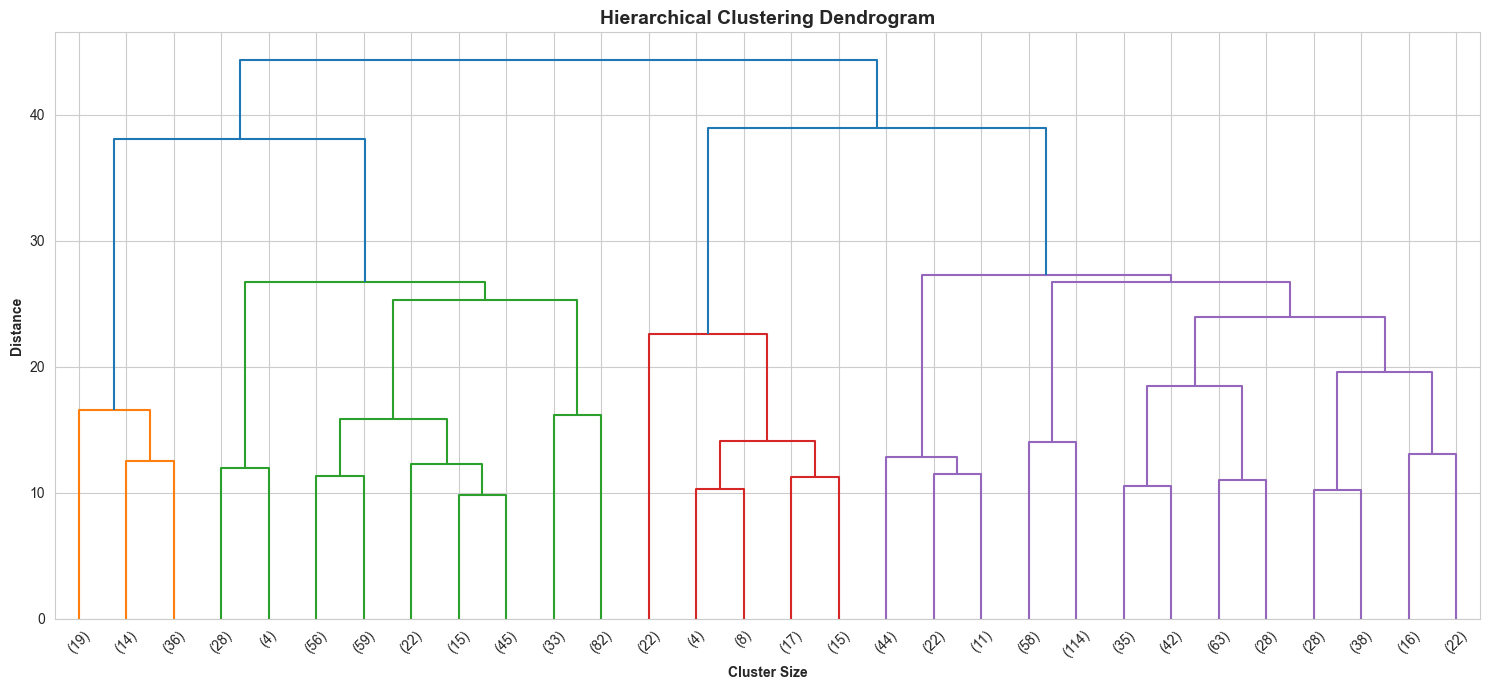

Hierarchical Clustering Evaluation:
  Silhouette Score: 0.264
  Davies-Bouldin Index: 1.862


In [6]:
print("\n[STEP 5] Hierarchical Clustering...")

# Use a sample for faster computation
sample_size = min(1000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Perform hierarchical clustering
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Size', fontweight='bold')
plt.ylabel('Distance', fontweight='bold')
plt.tight_layout()
plt.show()

# Apply Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)
df_clean['cluster_hierarchical'] = hierarchical_labels

print(f"Hierarchical Clustering Evaluation:")
print(f"  Silhouette Score: {silhouette_score(X_scaled, hierarchical_labels):.3f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, hierarchical_labels):.3f}")

**DBscan Clustering**


[STEP 6] DBSCAN Clustering...


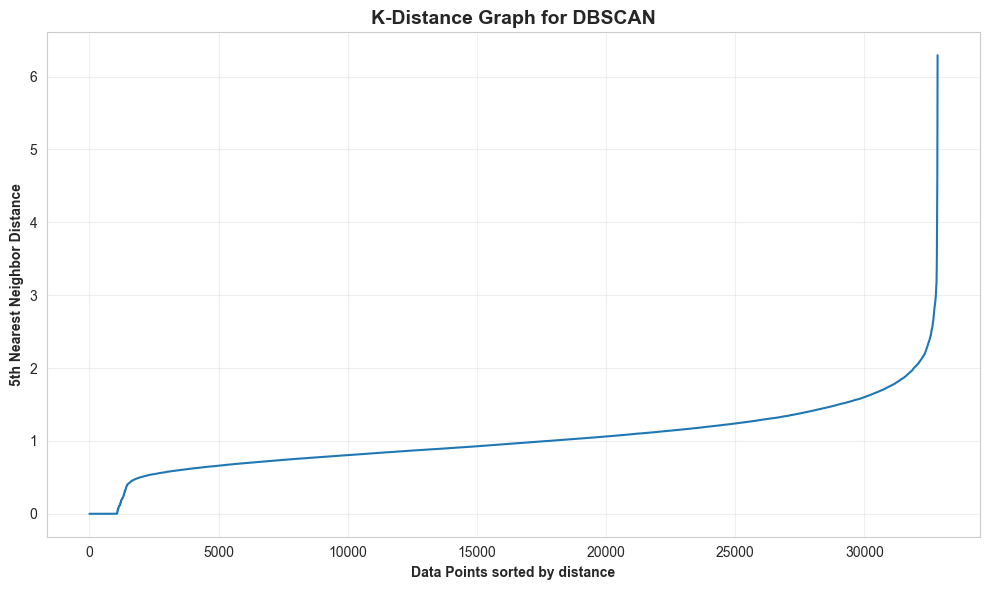

DBSCAN Results:
  Number of clusters: 4
  Number of noise points: 3086
  Silhouette Score (excluding noise): 0.161


In [7]:
print("\n[STEP 6] DBSCAN Clustering...")

# Find optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot k-distance graph
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points sorted by distance', fontweight='bold')
plt.ylabel('5th Nearest Neighbor Distance', fontweight='bold')
plt.title('K-Distance Graph for DBSCAN', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)
df_clean['cluster_dbscan'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Results:")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Number of noise points: {n_noise}")

if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    print(f"  Silhouette Score (excluding noise): {silhouette_score(X_scaled[mask], dbscan_labels[mask]):.3f}")

**Cluster Analysis**


[STEP 7] Cluster Analysis...

--- K-Means Cluster Characteristics ---

Cluster 0 (Size: 2605):
danceability             0.660821
energy                   0.785511
loudness                -6.948655
speechiness              0.072149
acousticness             0.071693
instrumentalness         0.737365
liveness                 0.190066
valence                  0.388615
tempo                  125.174574
duration_ms         251273.184645

Cluster 1 (Size: 10861):
danceability             0.553893
energy                   0.799374
loudness                -5.305921
speechiness              0.086884
acousticness             0.073003
instrumentalness         0.022412
liveness                 0.240904
valence                  0.414114
tempo                  132.433753
duration_ms         226771.561182

Cluster 2 (Size: 5406):
danceability             0.609067
energy                   0.436229
loudness               -10.378638
speechiness              0.091103
acousticness             0.497864
ins

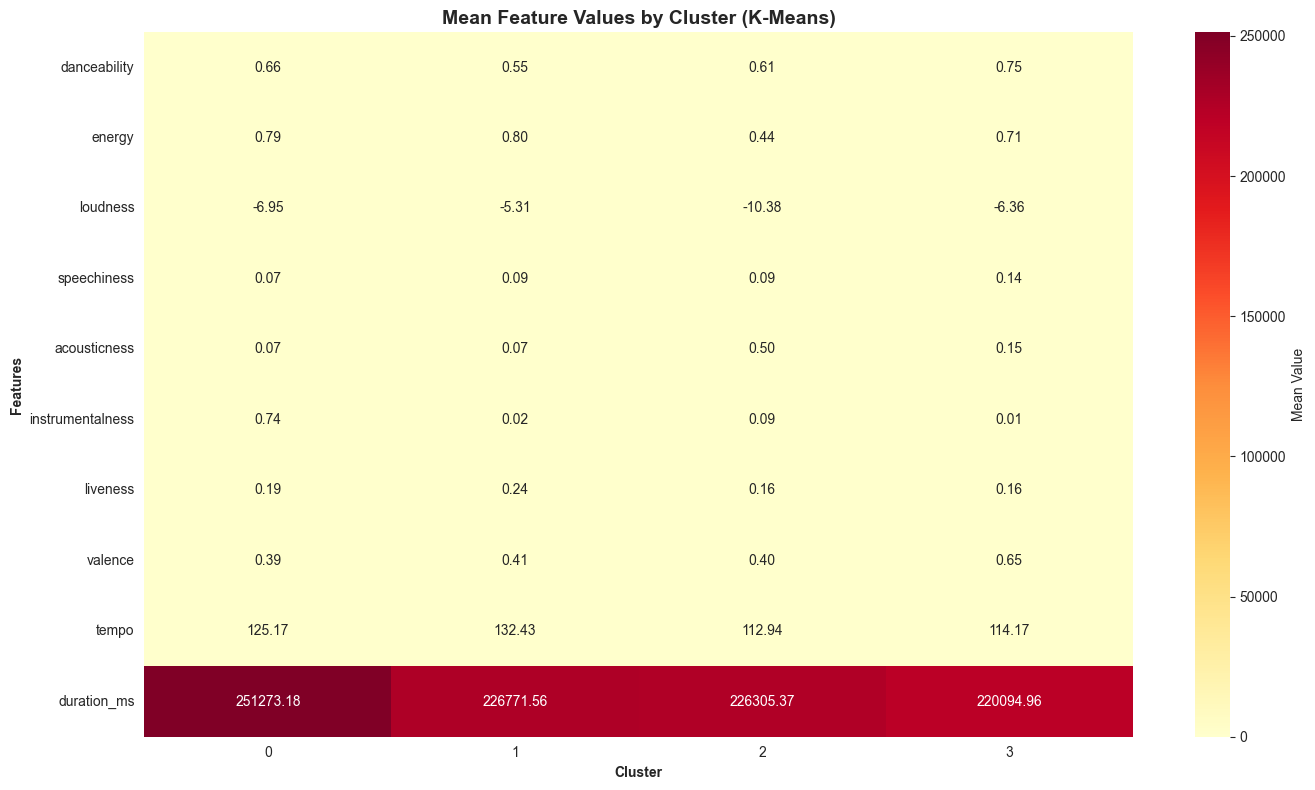

In [14]:
print("\n[STEP 7] Cluster Analysis...")

# Analyze K-Means clusters
print("\n--- K-Means Cluster Characteristics ---")
for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster_kmeans'] == cluster_id]
    print(f"\nCluster {cluster_id} (Size: {len(cluster_data)}):")
    print(cluster_data[feature_columns].mean().to_string())

# Visualize cluster characteristics
cluster_means = df_clean.groupby('cluster_kmeans')[feature_columns].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Value'})
plt.title('Mean Feature Values by Cluster (K-Means)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.tight_layout()
plt.show()

**Comparison of Clustering Techniques**


[STEP 9] Comparing Clustering Algorithms...

--- Algorithm Comparison ---
   Algorithm  Silhouette Score  Davies-Bouldin Index  Number of Clusters
     K-Means          0.133243              1.977177                   4
Hierarchical          0.263776              1.861932                   4
      DBSCAN          0.161040              0.820144                   4


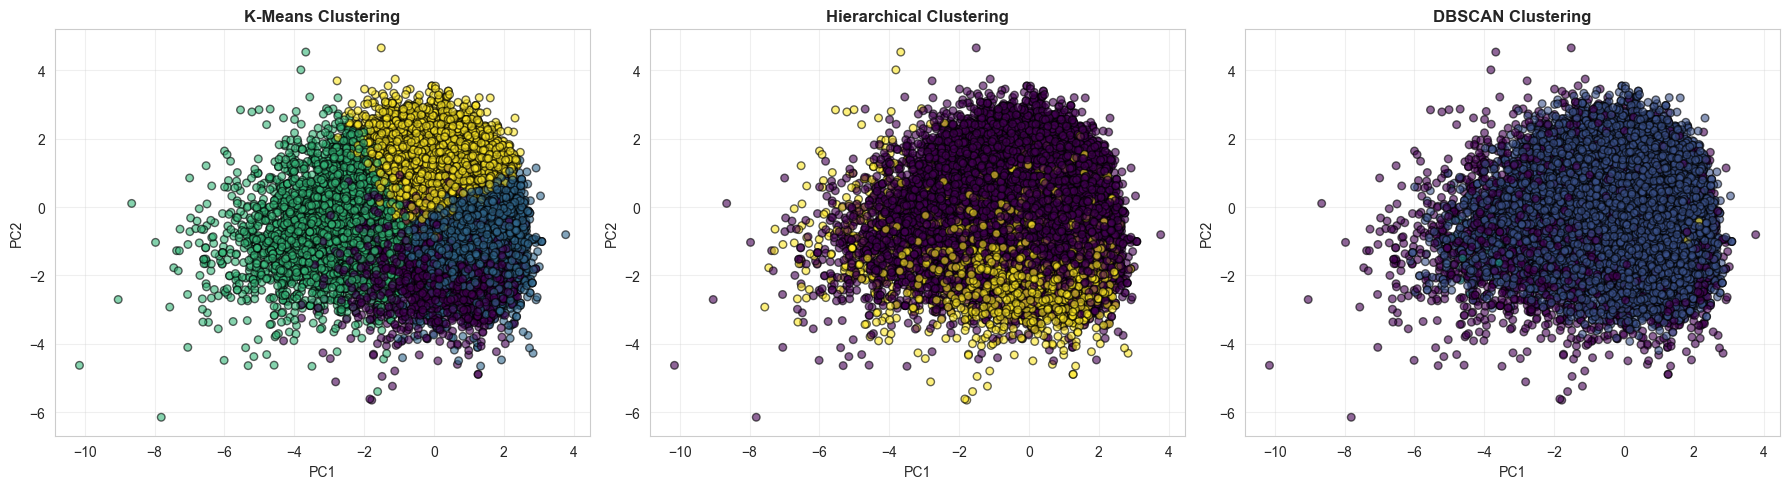


CLUSTERING ANALYSIS COMPLETE!

✓ All tasks completed successfully!
✓ You can now use the recommendation functions:
  - recommend_songs_by_user_preference(user_features, top_n)
  - get_cluster_playlist(cluster_id, top_n)


In [15]:
print("\n[STEP 9] Comparing Clustering Algorithms...")

comparison_data = {
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [
        silhouette_score(X_scaled, kmeans_labels),
        silhouette_score(X_scaled, hierarchical_labels),
        silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if n_clusters_dbscan > 1 else 0
    ],
    'Davies-Bouldin Index': [
        davies_bouldin_score(X_scaled, kmeans_labels),
        davies_bouldin_score(X_scaled, hierarchical_labels),
        davies_bouldin_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if n_clusters_dbscan > 1 else 0
    ],
    'Number of Clusters': [optimal_k, optimal_k, n_clusters_dbscan]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n--- Algorithm Comparison ---")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (labels, name) in enumerate([
    (kmeans_labels, 'K-Means'),
    (hierarchical_labels, 'Hierarchical'),
    (dbscan_labels, 'DBSCAN')
]):
    axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                     cmap='viridis', s=30, alpha=0.6, edgecolors='black')
    axes[idx].set_title(f'{name} Clustering', fontweight='bold')
    axes[idx].set_xlabel('PC1')
    axes[idx].set_ylabel('PC2')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("CLUSTERING ANALYSIS COMPLETE!")
print("=" * 80)
print("\n✓ All tasks completed successfully!")
print("✓ You can now use the recommendation functions:")
print("  - recommend_songs_by_user_preference(user_features, top_n)")
print("  - get_cluster_playlist(cluster_id, top_n)")

**Recommendation System**

In [12]:
print("\n[STEP 8] Preparing Recommendation System...")

# Merge back with original dataframe
df_with_clusters = df.iloc[df_clean.index].copy()
df_with_clusters['cluster'] = df_clean['cluster_kmeans']

def recommend_songs_by_user_preference(user_features, top_n=10):
    """
    Recommend songs based on user's music preference features
    """
    # Scale user features
    user_scaled = scaler.transform([user_features])
    
    # Predict cluster
    user_cluster = kmeans_final.predict(user_scaled)[0]
    
    # Get songs from the same cluster
    cluster_songs = df_with_clusters[df_with_clusters['cluster'] == user_cluster]
    
    # Sort by popularity if available
    if 'track_popularity' in cluster_songs.columns:
        recommendations = cluster_songs.nlargest(top_n, 'track_popularity')
    else:
        recommendations = cluster_songs.sample(min(top_n, len(cluster_songs)))
    
    return user_cluster, recommendations

def get_cluster_playlist(cluster_id, top_n=20):
    """
    Generate a playlist for a specific cluster
    """
    cluster_songs = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    if 'track_popularity' in cluster_songs.columns:
        playlist = cluster_songs.nlargest(top_n, 'track_popularity')
    else:
        playlist = cluster_songs.sample(min(top_n, len(cluster_songs)))
    
    return playlist

print("✓ Recommendation functions ready!")




print("\nInteractive Playlist Recommendation...")
print("=" * 80)

def interactive_recommendation():
    """
    Interactive function to get personalized music recommendations
    """
    print("\n🎵 PERSONALIZED MUSIC RECOMMENDATION SYSTEM 🎵")
    print("=" * 80)
    print("\nLet's find the perfect music for you!\n")
    
    # Ask user questions
    print("Please rate the following on a scale of 1-5:")
    print("(1 = Very Low, 2 = Low, 3 = Medium, 4 = High, 5 = Very High)\n")
    
    try:
        # Get user inputs
        danceability = int(input("💃 How danceable do you want the music? (1-5): "))
        energy = int(input("⚡ How energetic should the music be? (1-5): "))
        mood = int(input("😊 How happy/upbeat should the music be? (1-5): "))
        acoustic = int(input("🎸 How acoustic (vs electronic)? (1-5): "))
        instrumental = int(input("🎹 How instrumental (vs vocals)? (1-5): "))
        tempo_choice = int(input("🥁 Tempo preference? (1=Slow, 2=Moderate, 3=Fast): "))
        
        # Convert to feature values
        danceability_val = danceability / 5.0
        energy_val = energy / 5.0
        loudness_val = -15 + (energy * 3)  # Higher energy = louder
        speechiness_val = 0.1
        acousticness_val = acoustic / 5.0
        instrumentalness_val = instrumental / 5.0
        liveness_val = 0.2
        valence_val = mood / 5.0
        
        if tempo_choice == 1:
            tempo_val = 80
        elif tempo_choice == 2:
            tempo_val = 120
        else:
            tempo_val = 140
            
        duration_val = 200000
        
        user_features = [danceability_val, energy_val, loudness_val, speechiness_val,
                        acousticness_val, instrumentalness_val, liveness_val, 
                        valence_val, tempo_val, duration_val]
        
        # Get number of recommendations
        num_songs = int(input("\n🎵 How many songs would you like? (5-50): "))
        num_songs = max(5, min(50, num_songs))  # Limit between 5 and 50
        
        print("\n" + "=" * 80)
        print("🔍 ANALYZING YOUR PREFERENCES...")
        print("=" * 80)
        
        # Get recommendations
        user_cluster, recommendations = recommend_songs_by_user_preference(user_features, top_n=num_songs)
        
        # Display results
        print(f"\n✨ Based on your preferences, you've been assigned to Cluster {user_cluster}")
        
        # Show cluster characteristics
        cluster_chars = df_clean[df_clean['cluster_kmeans'] == user_cluster][feature_columns].mean()
        print(f"\n📊 Your Cluster's Music Profile:")
        print(f"   • Danceability: {cluster_chars['danceability']:.2f}")
        print(f"   • Energy: {cluster_chars['energy']:.2f}")
        print(f"   • Valence (happiness): {cluster_chars['valence']:.2f}")
        print(f"   • Tempo: {cluster_chars['tempo']:.0f} BPM")
        
        print(f"\n🎵 YOUR PERSONALIZED PLAYLIST ({len(recommendations)} songs):")
        print("=" * 80 + "\n")
        
        if 'track_name' in recommendations.columns:
            for idx, (i, row) in enumerate(recommendations.iterrows(), 1):
                print(f"{idx:2d}. 🎶 {row['track_name']}")
                print(f"     👤 Artist: {row['track_artist']}")
                if 'track_popularity' in recommendations.columns:
                    print(f"     ⭐ Popularity: {row['track_popularity']}/100")
                if 'playlist_genre' in recommendations.columns:
                    print(f"     🎸 Genre: {row['playlist_genre']}")
                print()
        else:
            print(recommendations[feature_columns[:5]])
        
        # Ask if user wants to explore other clusters
        print("\n" + "=" * 80)
        explore = input("\n🔍 Would you like to explore other music clusters? (yes/no): ").lower()
        
        if explore in ['yes', 'y']:
            print("\n📚 ALL AVAILABLE CLUSTERS:")
            print("=" * 80)
            for cid in range(optimal_k):
                cluster_data = df_clean[df_clean['cluster_kmeans'] == cid]
                print(f"\n🎵 Cluster {cid} ({len(cluster_data)} songs)")
                print(f"   Danceability: {cluster_data['danceability'].mean():.2f} | "
                      f"Energy: {cluster_data['energy'].mean():.2f} | "
                      f"Mood: {cluster_data['valence'].mean():.2f}")
            
            cluster_choice = int(input(f"\nWhich cluster would you like to explore? (0-{optimal_k-1}): "))
            if 0 <= cluster_choice < optimal_k:
                playlist = get_cluster_playlist(cluster_choice, top_n=10)
                print(f"\n🎵 Top 10 songs from Cluster {cluster_choice}:")
                print("=" * 80 + "\n")
                if 'track_name' in playlist.columns:
                    for idx, (i, row) in enumerate(playlist.iterrows(), 1):
                        print(f"{idx:2d}. {row['track_name']} - {row['track_artist']}")
        
        print("\n" + "=" * 80)
        print("✨ Thank you for using the Music Recommendation System! ✨")
        print("=" * 80)
        
    except ValueError:
        print("\n❌ Invalid input! Please enter numbers only.")
    except KeyboardInterrupt:
        print("\n\n👋 Recommendation cancelled by user.")
    except Exception as e:
        print(f"\n❌ An error occurred: {e}")

# Run the interactive recommendation
interactive_recommendation()


[STEP 8] Preparing Recommendation System...
✓ Recommendation functions ready!

Interactive Playlist Recommendation...

🎵 PERSONALIZED MUSIC RECOMMENDATION SYSTEM 🎵

Let's find the perfect music for you!

Please rate the following on a scale of 1-5:
(1 = Very Low, 2 = Low, 3 = Medium, 4 = High, 5 = Very High)


🔍 ANALYZING YOUR PREFERENCES...

✨ Based on your preferences, you've been assigned to Cluster 1

📊 Your Cluster's Music Profile:
   • Danceability: 0.65
   • Energy: 0.78
   • Valence (happiness): 0.53
   • Tempo: 124 BPM

🎵 YOUR PERSONALIZED PLAYLIST (10 songs):

 1. 🎶 ROXANNE
     👤 Artist: Arizona Zervas
     ⭐ Popularity: 99/100
     🎸 Genre: latin

 2. 🎶 ROXANNE
     👤 Artist: Arizona Zervas
     ⭐ Popularity: 99/100
     🎸 Genre: r&b

 3. 🎶 ROXANNE
     👤 Artist: Arizona Zervas
     ⭐ Popularity: 99/100
     🎸 Genre: r&b

 4. 🎶 ROXANNE
     👤 Artist: Arizona Zervas
     ⭐ Popularity: 99/100
     🎸 Genre: edm

 5. 🎶 Tusa
     👤 Artist: KAROL G
     ⭐ Popularity: 98/100
    